<a href="https://colab.research.google.com/github/Sanyam-Jain1/Plane_disease_classficiation/blob/main/train_mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import zipfile

In [ ]:
!unzip /content/Dataset.zip -d /content/Dataset

unzip:  cannot find or open /content/Dataset.zip, /content/Dataset.zip.zip or /content/Dataset.zip.ZIP.


In [ ]:
import zipfile
import os
with zipfile.ZipFile('/content/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset')


In [ ]:
import json
import random
import os
from collections import defaultdict

def split_coco_json(json_path, output_dir, val_ratio=0.2, seed=42):
    with open(json_path, 'r') as f:
        coco = json.load(f)

    random.seed(seed)

    # Group annotations by image_id
    annos_by_image = defaultdict(list)
    for ann in coco['annotations']:
        annos_by_image[ann['image_id']].append(ann)

    image_ids = list({img['id'] for img in coco['images']})
    random.shuffle(image_ids)

    val_count = int(len(image_ids) * val_ratio)
    val_ids = set(image_ids[:val_count])
    train_ids = set(image_ids[val_count:])

    def filter_images(ids):
        return [img for img in coco['images'] if img['id'] in ids]

    def filter_annotations(ids):
        return [ann for ann in coco['annotations'] if ann['image_id'] in ids]

    def create_coco_subset(ids):
        return {
            'info': coco.get('info', {}),
            'licenses': coco.get('licenses', []),
            'categories': coco['categories'],
            'images': filter_images(ids),
            'annotations': filter_annotations(ids)
        }

    os.makedirs(output_dir, exist_ok=True)

    with open(os.path.join(output_dir, 'train.json'), 'w') as f:
        json.dump(create_coco_subset(train_ids), f)

    with open(os.path.join(output_dir, 'val.json'), 'w') as f:
        json.dump(create_coco_subset(val_ids), f)

    print(f"Split completed. Train: {len(train_ids)} images, Val: {len(val_ids)} images.")

# Example usage:
split_coco_json('/content/final_coco_with_mask.json', '/content/split_annotations')


Split completed. Train: 9807 images, Val: 2451 images.


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install dextectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 19.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15868, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 15868 (delta 49), reused 16 (delta 16), pack-reused 15783 (from 3)
Receiving objects: 100% (15868/15868), 6.43 MiB | 19.65 MiB/s, done.
Resolving deltas: 100% (11548/11548), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances(
    "my_dataset_train", {},
    "/content/split_annotations/train.json",
    "/content/Dataset/Dataset"
)

register_coco_instances(
    "my_dataset_val", {},
    "/content/split_annotations/val.json",
    "/content/Dataset/Dataset"
)


In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "/content/model_final_f10217.pkl"

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.INPUT.MASK_FORMAT = "bitmask"

# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/..."  # COCO pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[05/27 15:27:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[05/27 15:27:46 d2.engine.train_loop]: Starting training from iteration 0


/content/detectron2/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/content/detectron2/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torc

[05/27 15:27:56 d2.utils.events]:  eta: 0:50:15  iter: 19  total_loss: 3.395  loss_cls: 2.074  loss_box_reg: 0.5462  loss_mask: 0.6945  loss_rpn_cls: 0.09998  loss_rpn_loc: 0.01469    time: 0.3043  last_time: 0.3200  data_time: 0.0294  last_data_time: 0.0077   lr: 4.9953e-06  max_mem: 1769M
[05/27 15:28:07 d2.utils.events]:  eta: 0:51:19  iter: 39  total_loss: 3.318  loss_cls: 1.938  loss_box_reg: 0.5989  loss_mask: 0.6933  loss_rpn_cls: 0.108  loss_rpn_loc: 0.02207    time: 0.3112  last_time: 0.3501  data_time: 0.0126  last_data_time: 0.0068   lr: 9.9902e-06  max_mem: 1771M
[05/27 15:28:14 d2.utils.events]:  eta: 0:51:21  iter: 59  total_loss: 2.999  loss_cls: 1.547  loss_box_reg: 0.4918  loss_mask: 0.692  loss_rpn_cls: 0.1564  loss_rpn_loc: 0.0209    time: 0.3133  last_time: 0.3357  data_time: 0.0125  last_data_time: 0.0054   lr: 1.4985e-05  max_mem: 1771M
[05/27 15:28:20 d2.utils.events]:  eta: 0:51:22  iter: 79  total_loss: 2.523  loss_cls: 1.159  loss_box_reg: 0.4839  loss_mask: 0

In [ ]:
import requests
requests.get("https://google.com")


<Response [200]>

In [ ]:
print(cfg.MODEL.WEIGHTS)

detectron2://COCO-InstanceSegmentation/...


In [ ]:
# prompt: download output folder as a zip file

from google.colab import files
import shutil

output_dir = '/content/output'  # This should be defined in the preceding code

# Create a zip file of the output directory
shutil.make_archive(output_dir, 'zip', output_dir)

# Download the zip file
files.download(f'{output_dir}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set up evaluator
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Run evaluation
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
print(metrics)


[05/27 16:37:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/27 16:37:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 16:37:45 d2.data.datasets.coco]: Loaded 2451 images in COCO format from /content/split_annotations/val.json
[05/27 16:37:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/27 16:37:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/27 16:37:45 d2.data.common]: Serializing 2451 elements to byte tensors and concatenating them all ...
[05/27 16:37:45 d2.data.common]: Serialized dataset takes 2.95 MiB
[05/27 16:37:45 d2.evaluation.evaluator]: Start inference on 2451 batches
[05/27 16:37:46 d2.evaluation.evaluator]: Inference done 11/2451. Dataloading: 0.0015 s/it

KeyError: 'area'

WARNING [05/27 16:43:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 16:43:08 d2.data.datasets.coco]: Loaded 2451 images in COCO format from /content/split_annotations/val.json


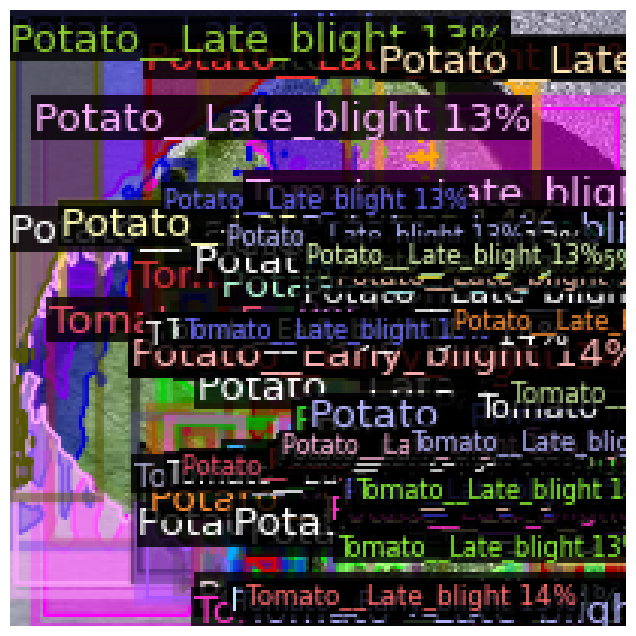

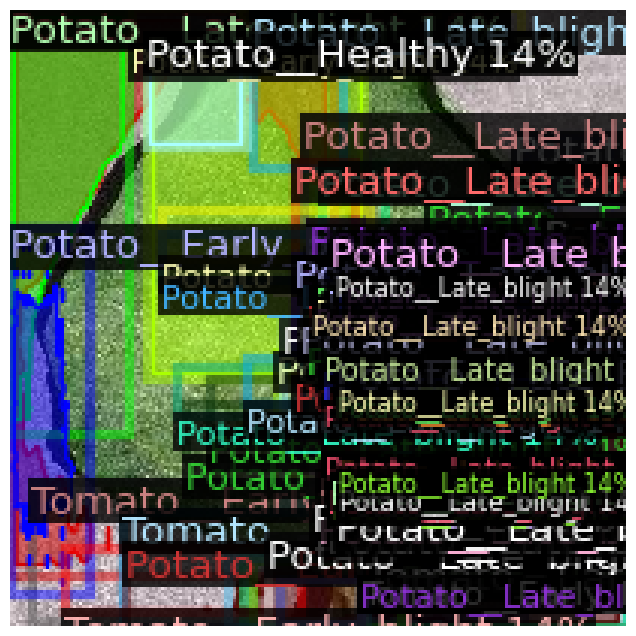

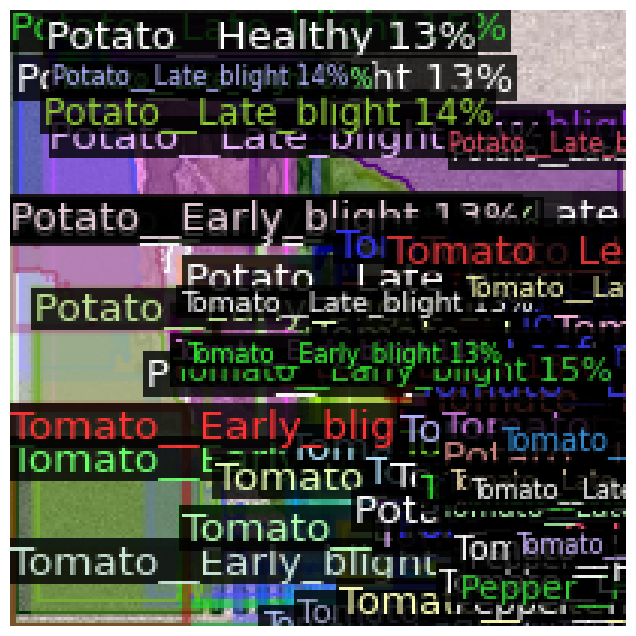

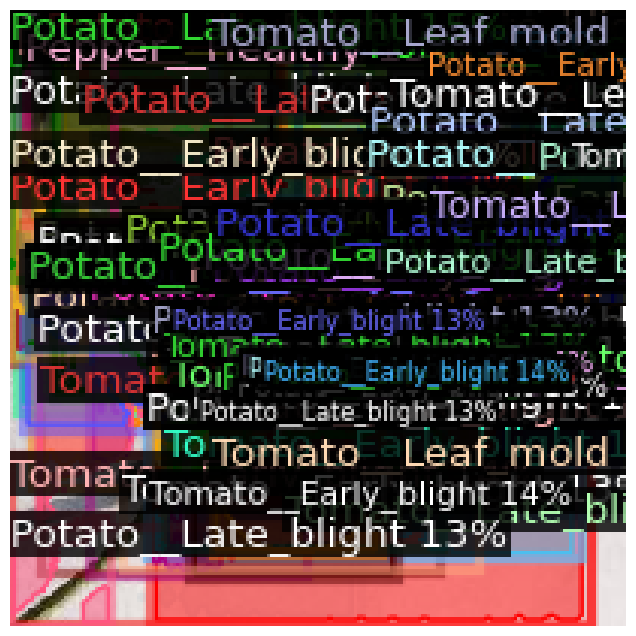

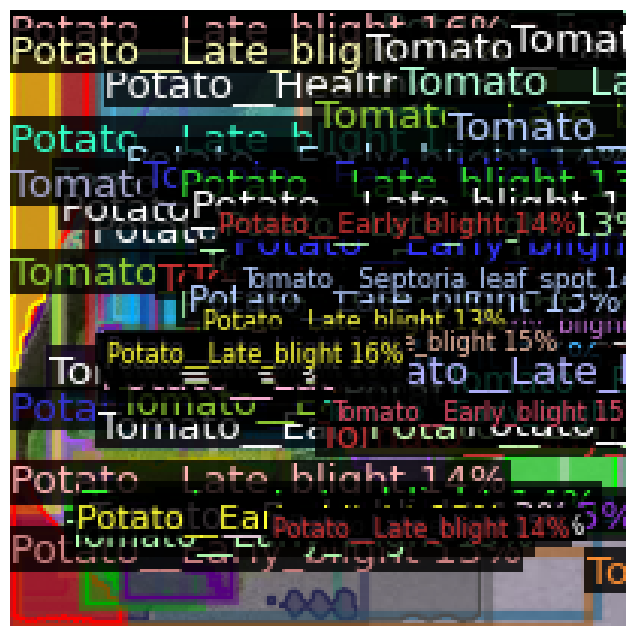

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import random
import matplotlib.pyplot as plt

# Load metadata
metadata = MetadataCatalog.get("my_dataset_val")

# Load some sample images from val set
dataset_dicts = DatasetCatalog.get("my_dataset_val")

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  # runs the model
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Show with matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()


In [ ]:
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)


[05/27 16:43:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
